# Calculate Job Power Schedules with LP

This program is designed to take in n number of distinct power scheduling jobs and determine their ideal ordering in to minimize the peak amount of power demand above a provided resource curve. 
\
This is a relaxed ILP problem. Therefore, it uses typical LP to solve the problem in polynomial time and then probability to estimate the optimal schedule of jobs.


In [746]:
import cplex
import random
import json
import matplotlib.pyplot as plt
import numpy as np

# Generate Jobs and Decision Variables
We need to generate the jobs, decision variables and extract other information that will be necessary for the LP to run

The Jobs used for the LP will be instantiated here. Each job will have the following format:
\
\
&emsp;&emsp;**release** -> The minimum time that a specific job can begin by. A job can begin no earlier than the release time \
&emsp;&emsp;**deadline** -> The maximum time that a job must complete by. A job can end no later than the deadline time \
&emsp;&emsp;**duration** -> The length (in minutes) that a task will need to complete \
&emsp;&emsp;**height** -> The amount of consistent power that a task will require

In [747]:
jobs = [ 
    {'release' : 0, 'deadline' : 4, 'duration' : 2, 'height' : 1},  
    {'release' : 1, 'deadline' : 6, 'duration' : 1, 'height' : 2},
    {'release' : 3, 'deadline' : 8, 'duration' : 2, 'height' : 1},
    {'release' : 4, 'deadline' : 6, 'duration' : 2, 'height' : 2},
    {'release' : 0, 'deadline' : 5, 'duration' : 1, 'height' : 1},
    {'release' : 3, 'deadline' : 7, 'duration' : 1, 'height' : 1},
    {'release' : 5, 'deadline' : 7, 'duration' : 1, 'height' : 3},
    {'release' : 0, 'deadline' : 8, 'duration' : 1, 'height' : 2},
]

start_time = 0
end_time = 9

# jobs = [
#     {'release' : 0, 'deadline' : 2, 'duration' : 1, 'height' : 2},
#     {'release' : 0, 'deadline' : 3, 'duration' : 1, 'height' : 3},
#     {'release' : 1, 'deadline' : 3, 'duration' : 1, 'height' : 1},
# ]

# This is The list of job objects that will be scheduled
# They each have a release, deadline, duration and height
# path = '../../Data/job_data.json'
# with open(path, 'r') as file:
#     data = json.load(file)

# start_time = 600
# end_time = 1200
# max_length = 500
# batch_size = 20

# # Randomly shuffle the jobs so that there is variation between trials
# jobs_array = data['jobs']
# random.shuffle(jobs_array)

# jobs = []

# # Iterate through the job objects and create an array of objects that fall within the specified time window
# i = 0
# curr_index = 0
# while (i < batch_size):
#     aj = jobs_array[curr_index]['release']
#     dj = jobs_array[curr_index]['deadline']
#     lj = jobs_array[curr_index]['length']

#     # Check if the specific job lies within the correct window
#     # The funky syntax is used to put the job id at the very front of the dictionary
#     if aj >= start_time and dj <= end_time and lj <= max_length:
#         job_id = {'job_id' : i}
#         jobs.append({**job_id, **jobs_array[curr_index]})
#         i += 1
    
#     curr_index += 1


# for job in jobs:
#     print(job, ",")

In [748]:
# This creates j number of distinct sub-lists where j is the number of jobs
# Each sublist contains all of the finite possible intervals during which job j could be executed
intervals = [[] for _ in range(len(jobs))]
for i, job in enumerate(jobs):
    release = job['release'] - start_time
    deadline = job['deadline'] - start_time
    duration = job['duration']
    num = release

    while (num + duration <= deadline):
        intervals[i].append((num, num + duration))
        num += 1

# This establishes the height of each job
# This can be accessed later during the execution of the linear program
height = [job['height'] for job in jobs]

# This represents each distinct time step
# It could be easily replaced with a set integer representing the number of time steps
# In a certain period
num_time_steps = end_time - start_time

# This list will represent the value of the resource curve at each distinct time step
# However, for now, it will be left 0 for all time steps for the purposes of debugging
# resources = [0 for _ in range(num_time_steps)]
resources = [0, 2, 3, 2, 4, 4, 3, 1, 1]

This creates a list of objects with the form {'name': x_i_j, value: ?} where each name is a distinct time interval for a distinct job. These will represent all of the decision variables for the ILP.
\
\
Specifically, this is saying that decision variable x_i_j is the ith possible interval for job j where the value is the actual interval of time steps. This is stored here so we don't have to repeatedly query the intervals list

In [749]:
decision_variables = []
for j, interval_set in enumerate(intervals):
    for i, interval in enumerate(interval_set):
        decision_variables.append({'name' : f'x_{i}_{j}', 'value': interval})

# This is the name of the objective variable that we will minimize
objective_variable = 'd'

for d in decision_variables:
    print(d)

{'name': 'x_0_0', 'value': (0, 2)}
{'name': 'x_1_0', 'value': (1, 3)}
{'name': 'x_2_0', 'value': (2, 4)}
{'name': 'x_0_1', 'value': (1, 2)}
{'name': 'x_1_1', 'value': (2, 3)}
{'name': 'x_2_1', 'value': (3, 4)}
{'name': 'x_3_1', 'value': (4, 5)}
{'name': 'x_4_1', 'value': (5, 6)}
{'name': 'x_0_2', 'value': (3, 5)}
{'name': 'x_1_2', 'value': (4, 6)}
{'name': 'x_2_2', 'value': (5, 7)}
{'name': 'x_3_2', 'value': (6, 8)}
{'name': 'x_0_3', 'value': (4, 6)}
{'name': 'x_0_4', 'value': (0, 1)}
{'name': 'x_1_4', 'value': (1, 2)}
{'name': 'x_2_4', 'value': (2, 3)}
{'name': 'x_3_4', 'value': (3, 4)}
{'name': 'x_4_4', 'value': (4, 5)}
{'name': 'x_0_5', 'value': (3, 4)}
{'name': 'x_1_5', 'value': (4, 5)}
{'name': 'x_2_5', 'value': (5, 6)}
{'name': 'x_3_5', 'value': (6, 7)}
{'name': 'x_0_6', 'value': (5, 6)}
{'name': 'x_1_6', 'value': (6, 7)}
{'name': 'x_0_7', 'value': (0, 1)}
{'name': 'x_1_7', 'value': (1, 2)}
{'name': 'x_2_7', 'value': (2, 3)}
{'name': 'x_3_7', 'value': (3, 4)}
{'name': 'x_4_7', 'v

# Solve the ILP
Set up the necessary equations and constraints in order to solve the LP problem

**Important** - In this program, all of the decision variables are set to be continuous rather than integers. Therefore, they can assume real values.

In [750]:
# Create the cplex problem
problem = cplex.Cplex()
problem.set_problem_type(cplex.Cplex.problem_type.LP)
problem.set_results_stream(None)

# Maximize objective
problem.objective.set_sense(problem.objective.sense.minimize)

# This retrieves the names of all of the decision variables 
names = [variable['name'] for variable in decision_variables] + [objective_variable]

# these are the other parameters needed to form the basis of the linear programming problem
obj = [0 for _ in range(len(decision_variables))] + [1]# only minimizing d
lb = [0 for _ in range(len(decision_variables))] + [0]
ub = [1 for _ in range(len(decision_variables)) ] + [sum(height)]

# Establish the problem
types = [problem.variables.type.continuous] * (len(decision_variables)) + [problem.variables.type.continuous]
problem.variables.add(obj=obj, lb=lb, ub=ub, types=types, names=names)

range(0, 33)

This will generate the first set of constraints

This for loop adds the constraints that make it so that a job can run during only one interval. So for each job, aggregate all of the decision variables that correspond to each possible execution interval for that job. Then specify that they all of those decision variables can only add up to one  

In [751]:
curr_index = 0
for i, interval in enumerate(intervals):
    if i == 0:
        variables = decision_variables[i : i + len(interval)]
        variables = [v['name'] for v in variables]
        curr_index += len(interval)
    elif i > 0:
        variables = decision_variables[curr_index : curr_index + (len(interval))]
        variables = [v['name'] for v in variables]
        curr_index += len(interval)
    
    # The coefficient of each decision variable is one
    constraints = [1 for _ in range(len(variables))]

    # This is saying that the sum of each of the decision variabels can only equal one
    problem.linear_constraints.add(
        lin_expr=[ [ variables, constraints ] ],
        senses=['E'],
        rhs=[1]
    )


This generates the second set of constraints 
\
\
It aggregates all of the desicion variables that correspond to intervals that could possibly be running during that time step. /
It then aggregates the heights corresponding to the jobs that each decision variable represents. 
It multiplies those heights by the decision variables. However, the constrain ensures that the total sum is less than the max height d

In [752]:
total = 0
for i in range(num_time_steps):
    use_variables = []
    use_height = []

    for variable in decision_variables:
        
        # Check the interval times of the corresponding variable
        # Then check if the current timestep falls within that interval
        job_interval_start, job_interval_end = variable['value'][0] - start_time, variable['value'][1] - start_time

        # if i >= job_interval_start and i <= job_interval_end: #COME BACK TO THIS
        if job_interval_start <= i < job_interval_end:
            job_id = int(variable['name'].split('_')[-1])

            use_height.append(height[job_id])
            use_variables.append(variable['name'])

    # Add d to the decision variables 
    use_variables.append('d')
    use_height.append(-1)

    # print(use_variables, use_height)

    # Add the linear constraint to the problem
    problem.linear_constraints.add(
        lin_expr=[ [ use_variables, use_height ] ],
        senses=['L'],
        rhs=[resources[i]]
    )
    total += 1

print(total)


9


# Solve the LP problem

Use CPLEX to solve the formulated LP problem and then use post processing to extract the intervals each job will run in.

In [753]:
problem.solve()
solution = problem.solution

print("done")

done


# Choose the job intervals
Each decision variable for a specific job will have a value between 0-1. However, we need to choose exactly one interval for a specific job to run in.
\
\
Therefore, we use the values of the decision variables as a probability that that specific interval will run. This means that if a decision variable has a higher value, it's corresponding interval has a higher likelihood of being chosen for the job. 

In [754]:
# Loop through each of the jobs and generate a random number
# Choose a decision variable based on the probability of the current value of the decision variables
# Add that chosen variable to a final list so that the overall objective value can be ascertained
final_intervals = []
final_heights = [0 for _ in range(num_time_steps)]

curr_index = 0
# Loop through each job
for job_id in range(len(intervals)):
    # Generate a random number for the job to be used to select a specific interval
    random_num = random.uniform(0, 1)
    probability = 0

    # Loop through each interval in the job and get the value corresponding to each interval (decision variable)
    # Add the decision variable to the final interval list based on the random number 
    for i, interval in enumerate(intervals[job_id]):
        decision_variable = decision_variables[curr_index]
        decision_value = solution.get_values(decision_variable['name'])
        probability += decision_value

        if random_num <= probability and len(final_intervals) <= job_id:
            final_intervals.append(decision_variable)
        
        curr_index += 1

# Generate the height of all of the jobs over the course of all of the time steps
# Do this by iterating through all of the selected job intervals in final_intervals and add their height values 
# to the final_heights arrays. From this we can determine the objective value of d
# simply take the maximum from this height list
for job_id, job in enumerate(final_intervals):
    job_start = job['value'][0]
    job_end = job['value'][1]
    job_height = height[job_id]

    for i in range(job_start, job_end):
        final_heights[i] += job_height

We calculate the objective value to be the greatest difference between the job scheduling curve and the resource curve.

In [755]:
# This code obtains the objctive value of the entire problem
# It gathers the largest distance between the job scheduling curve and the resource curve
objective_value = 0
for i, heights in enumerate(final_heights):
    if heights - resources[i] > objective_value:
        objective_value = heights - resources[i]

# print(final_intervals)
# print(final_heights)

print("Objective value:", objective_value)

Objective value: 1


# Plot the Jobs

Use Matplotlib to plot the jobs on a curve

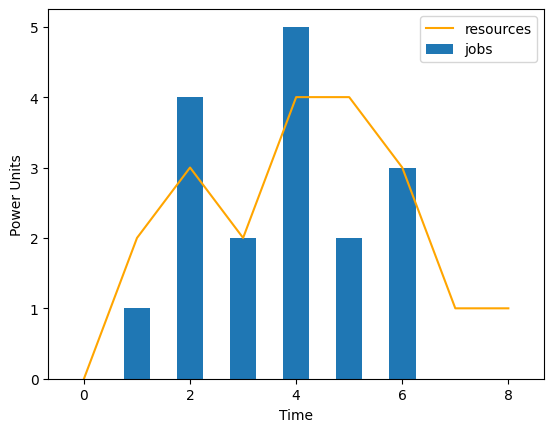

In [756]:
job_graph_xvalues = np.array([i for i in range(num_time_steps)])
job_graph_yvalues = np.array(final_heights)

plt.bar(job_graph_xvalues, job_graph_yvalues, label='jobs', width=0.5)
plt.plot(job_graph_xvalues, resources, label='resources', color='orange')

plt.xlabel("Time")
plt.ylabel("Power Units")
plt.legend()

plt.show()